In [3]:
from collections import defaultdict
from run import ScriptArguments, get_pz_list
from datasets import fingerprint
from transformers import HfArgumentParser, set_seed
import torch
from typing import cast
from datasets.utils._dill import dumps

results = defaultdict(list)
configs = {}
for seed in range(10):
    for max_xw in [100, 1000]:
        for model_name in ['meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-70B']:
            set_seed(seed)
            parser = HfArgumentParser((ScriptArguments))
            config = cast(ScriptArguments, parser.parse_args_into_dataclasses(f"--debug=False --api='togetherai' --seed={seed} --model_name={model_name} --max_w={max_xw} --max_x={max_xw} --pz_end=600 --pz_start=2 --pz_dist=log --pz_count=50 --num_test_examples=10 --device='cuda:1'".replace('\'', '').split())[0])
            fp = fingerprint.Hasher().hash(config.__dict__)
            all_answers = torch.load(f'{config.out_dir}/cache/{fp}/answers.pt')
            all_targets = torch.load(f'{config.out_dir}/cache/{fp}/targets.pt')
            mse = (all_answers - all_targets).float().pow(2)
            results[(max_xw, model_name)].append(mse)
            configs[(max_xw, model_name)] = config

results = {k: torch.stack(results[k]) for k in results}


In [7]:
results[(100, 'meta-llama/Meta-Llama-3-8B')].mean(dim=1).sqrt().mean(dim=0)

tensor([3476.4062, 3148.9587, 2556.4194, 2595.2109, 1852.6873, 1590.4226,
        1593.6038, 1304.7747, 1465.4832, 1244.1934, 1091.3479, 1097.0013,
         921.4675,  791.8152,  775.7568,  918.2425,  566.2471,  583.6151,
         507.6691,  557.4315,  356.5268,  587.7896,  311.9843,  361.5512,
         310.8254,  363.1408,  300.9827,  287.2368,  202.4361,  230.8446,
         223.3730,  208.4605,  199.3698,  218.2219,  187.1746,  168.0087,
         213.3940,  141.0151,  138.1813,  154.8964,  129.7170,  125.7269,
         126.3395,  119.2881])

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


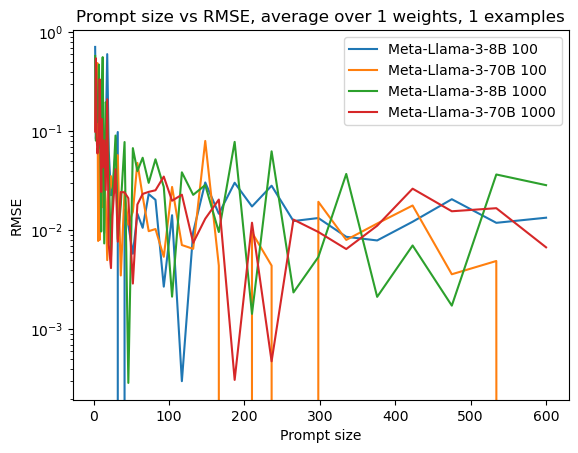

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


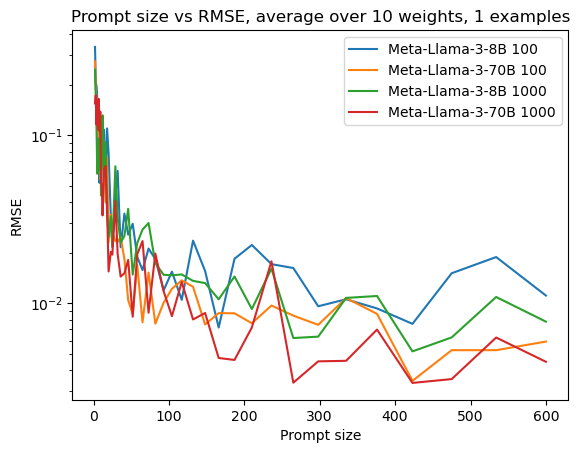

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


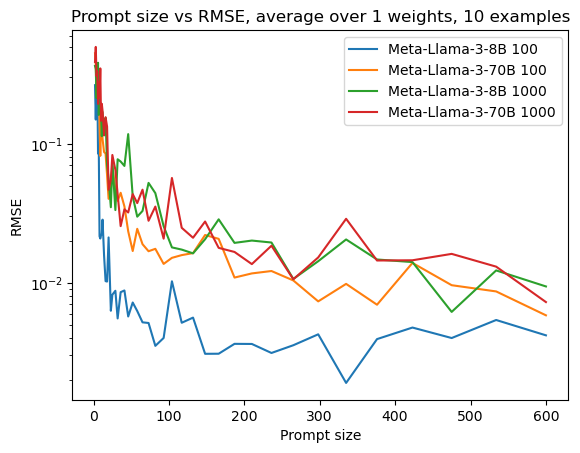

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


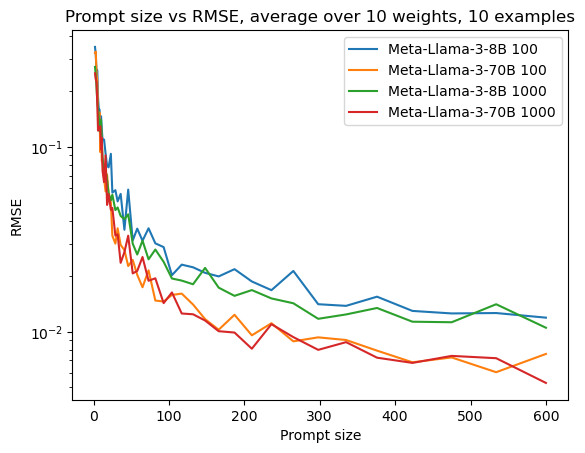

In [12]:
from matplotlib import pyplot as plt
from random import randint

def remove_outliers(data, labels):
    return data[data <= 1], labels[data <= 1]

for avg_over_x in [1, 10]:
    for avg_over_w in [1, 10]:
        plt.figure()
        for k in results:
            i, j = randint(0, results[k].shape[0] - avg_over_w), randint(0, results[k].shape[1] - avg_over_x)
            dat = results[k][i:avg_over_w+i, j:avg_over_x+j].mean(dim=1).sqrt().mean(dim=0) / (configs[k].max_w * configs[k].max_x)
            labels = torch.tensor(get_pz_list(configs[k]))
            dat, labels = remove_outliers(dat, labels)
            plt.plot(labels, dat, label=f'{k[1].split("/")[1]} {k[0]}')
        plt.xlabel('Prompt size')
        plt.ylabel('RMSE')
        plt.semilogy()
        plt.legend()
        plt.title(f'Prompt size vs RMSE, average over {avg_over_w} weights, {avg_over_x} examples')
        plt.show()


In [ ]:
# results[(1000, 'meta-llama/Meta-Llama-3-70B')]

tensor([[3.8814e-01, 4.9779e-01, 3.0688e-01, 3.3176e-01, 1.9380e-01, 2.7565e-01,
         2.1504e-01, 3.4876e-01, 1.4635e-01, 1.9395e-01, 1.7255e-01, 1.1516e-01,
         1.5523e-01, 1.3299e-01, 4.6699e-02, 5.5448e-02, 8.3097e-02, 6.4943e-02,
         4.3432e-02, 2.5580e-02, 3.3756e-02, 3.2060e-02, 4.3459e-02, 3.7451e-02,
         4.6777e-02, 2.7957e-02, 3.5349e-02, 2.0778e-02, 5.6760e-02, 2.4870e-02,
         2.1094e-02, 2.7602e-02, 1.7841e-02, 1.6673e-02, 1.3633e-02, 1.8481e-02,
         1.0603e-02, 1.5221e-02, 2.8869e-02, 1.4472e-02, 1.4525e-02, 1.6149e-02,
         1.3072e-02, 7.2690e-03],
        [1.6139e-01, 7.4380e-02, 1.8817e-01, 1.0636e-01, 9.4553e-02, 1.3580e+03,
         1.2463e-01, 9.4897e-02, 5.9028e-02, 6.4604e-02, 4.0046e-02, 8.9521e-02,
         2.8747e-02, 6.6955e-02, 4.4988e-02, 4.8974e-02, 5.1138e-02, 2.4582e-02,
         3.1655e-02, 3.0311e-02, 1.3375e-02, 2.1633e-02, 2.1006e-02, 1.7076e-02,
         2.4558e-02, 1.0545e-02, 2.9110e-02, 6.0751e-03, 1.6084e-02, 1.3031